In [225]:
%%capture stored_output
%load_ext autoreload
%autoreload 2


# Visualize results

In [226]:
import os
import pandas as pd
import seaborn as sns
import datetime
import traceback
from ipywidgets import interact, widgets
from IPython.display import display, clear_output
from typing import List
from itertools import cycle

global tables, algos, palette_dict, metrics
global plot_output, load_output, env_w, algo_w, scorers_w, type_w, aggregate_w, save_w
tables = {}
algos = []
metrics = []
palette_dict = {}


In [244]:
def plot_df(b):
    with plot_output:
        try:
            env_name = env_w.value
            algo_list = algo_w.value
            scorers_list = scorers_w.value
            plot_type = type_w.value
            aggregate = aggregate_w.value
            save = save_w.value
            
            
            if not algo_list:
                print("Please, select algorithms to visualize")
                return
            if not scorers_list:
                print("Please, select scorers to visualize")
                return
            
            df = tables[env_name]
            
                

            df = df.loc[df['algo'].isin(algo_list)]
            df = df.loc[df['metric'].isin(scorers_list)]
            #df = df.loc[df['seed'].isin([20])]
            df = df.reset_index()
            
            if (df.empty):
                print("Selection not available. Data frame is empty")
                return
            print("Plotting {} of {} with {} and {}, aggregate: {}".format(plot_type, env_name, algo_list, scorers_list, aggregate))
            
            if (plot_type == 'steps'):
                if (aggregate):
                    df = df.drop(columns =['seed'], errors='ignore')
                    plot = sns.FacetGrid(
                        data=df,
                        col="metric",
                        hue="algo",  
                        height=5,
                        aspect=1.7,
                        legend_out=True,
                        sharey=False,
                        sharex=False,
                        palette=palette_dict,
                    )
                    plot.map_dataframe(sns.lineplot, "step", "value")
                    plot.add_legend()

                else:
                    plot = sns.FacetGrid(
                        data=df,
                        col="metric",
                        hue="algo",
                        row="seed",   
                        height=5,
                        aspect=1.7,
                        legend_out=True,
                        sharey=False,
                        sharex=False,
                        palette=palette_dict,
                    )
                    plot.map_dataframe(sns.lineplot, "step", "value")
                    plot.add_legend()
            else:
                df = df.sort_values(by=['value'], ascending = False)
                df_group = df.groupby(["algo", "metric"])
                match plot_type:
                    case "max":
                        df = df_group.max().reset_index()
                    case "min":
                        df = df_group.min().reset_index()
                    case "avg":
                        df = df_group.mean().reset_index()
                    case "std deviation":
                        #df = df.loc[df['seed'].isin([10])]
                        df = df.groupby(["algo", "metric"]).head(5).reset_index(drop=True)
                        df = df.groupby(["algo", "metric"])
                        df = df.mean().reset_index()
                        

                g = sns.catplot(
                    data=df,
                    x="algo",
                    hue="algo",
                    y="value",
                    col="metric",
                    #col_wrap=2,
                    kind="bar",
                    height=6,
                    aspect=1,
                    dodge=False,
                    palette=palette_dict,
                    legend=True,
                    sharey=False,
                    sharex=False,
                )
                sns.set_theme(style="ticks")
                #sns.set(rc={'figure.figsize':(22.7,23.27)})

               # g.fig.suptitle(plot_type)
                #g.add_legend()
                #g.set(xticklabels=[])
                
                axs = [g.facet_axis(0, i) for i in range(df["metric"].nunique())]
                for ax in axs:
                    for c in ax.containers:
                        labels = [f"{(v.get_height()):.1f}" for v in c]
                        ax.bar_label(c, labels=labels, label_type="edge")  
            
            if save:
                plot.savefig("{}_{}.png".format(env_name,datetime.datetime.now().strftime("%d%m%Y_%H%M")))
            print("Done!")
        except ValueError:
                print("It was not possible to plot the requested data")
                print(traceback.format_exc())
    return

In [245]:
def load_data(b):
    global tables, algos, palette_dict, metrics
    clear_output(wait=False)
    with load_output:
        env_folders = [ f.path for f in os.scandir("results") if f.is_dir() ]

        for folder in env_folders:
            for filename in os.scandir(folder):
                if filename.name.endswith('.parquet'):
                    env_name = folder.split('/')[1]
                    df = pd.read_parquet(filename.path)    #get dataframe from parquet
                    tables[env_name] = df

        #get list of used algorithms
        algos = [algo for table in tables.values() for algo in table["algo"].unique()]
        algos = list(dict.fromkeys(algos))
        algos.sort()
        
        #get list of used scorers
        metrics = [scorer for table in tables.values() for scorer in table["metric"].unique()]
        metrics = list(dict.fromkeys(metrics))
        metrics.sort()

        #construct colors palette (fix color for each algo)
        palette_dict = {
            continent: color
            for continent, color in zip(algos, cycle(sns.color_palette("tab10")))
        }
    run_visualizer()
    return

In [246]:
def run_visualizer():
    global plot_output, load_output, env_w, algo_w, scorers_w, type_w, aggregate_w, save_w
    
    load_butt = widgets.Button(
        description="Refresh",
        button_style='success',
        icon='fa-refresh'#'check',
    )
    load_output = widgets.Output()
    load_butt.on_click(load_data)

    plot_butt = widgets.Button(
        description="Show results",
        button_style='success',
        icon='fa-line-chart',
    )
    plot_output = widgets.Output()
    plot_butt.on_click(plot_df)

    env_w = widgets.ToggleButtons(
        options=list(tables.keys()),
        description='Environment: ',
        layout={'width': 'max-content'},
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
        continuous_update=True
    )

    algo_w = widgets.SelectMultiple(
        options=algos,
        description='Algorithms: ',
        layout={'width': 'max-content'},
        disabled=False,
        rows=10,
        continuous_update=True
    )
    
    scorers_w = widgets.SelectMultiple(
        options=metrics,
        description='Scorers: ',
        layout={'width': 'max-content'},
        disabled=False,
        rows=6,
        continuous_update=True
    )
    
    type_w = widgets.ToggleButtons(
        options=['steps', 'max', 'avg', 'min', 'std deviation'],
        description='Plot type: ',
        layout={'width': 'max-content'},
        disabled=False,
        button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
        continuous_update=True
    )


    aggregate_w = widgets.Checkbox(
        value=False,
        description='Aggregate trials? ',
        disabled=False,
        indent=False

    )
    
    save_w = widgets.Checkbox(
        value=False,
        description='Save graph? ',
        disabled=False,
        indent=False

    )
    
    display(load_butt, load_output)
    display(env_w)
    display(algo_w)
    display(scorers_w)
    display(type_w)
    display(widgets.HBox((aggregate_w, save_w)))

    display(plot_butt, plot_output)
    

Button(button_style='success', description='Refresh', icon='refresh', style=ButtonStyle())

Output()

ToggleButtons(button_style='info', description='Environment: ', layout=Layout(width='max-content'), options=('…

SelectMultiple(description='Algorithms: ', layout=Layout(width='max-content'), options=('0.001 AugmentedBCQ', …

SelectMultiple(description='Scorers: ', layout=Layout(width='max-content'), options=('evaluate_on_environment'…

ToggleButtons(button_style='warning', description='Plot type: ', layout=Layout(width='max-content'), options=(…

Button(button_style='success', description='Show results', icon='line-chart', style=ButtonStyle())

Output()

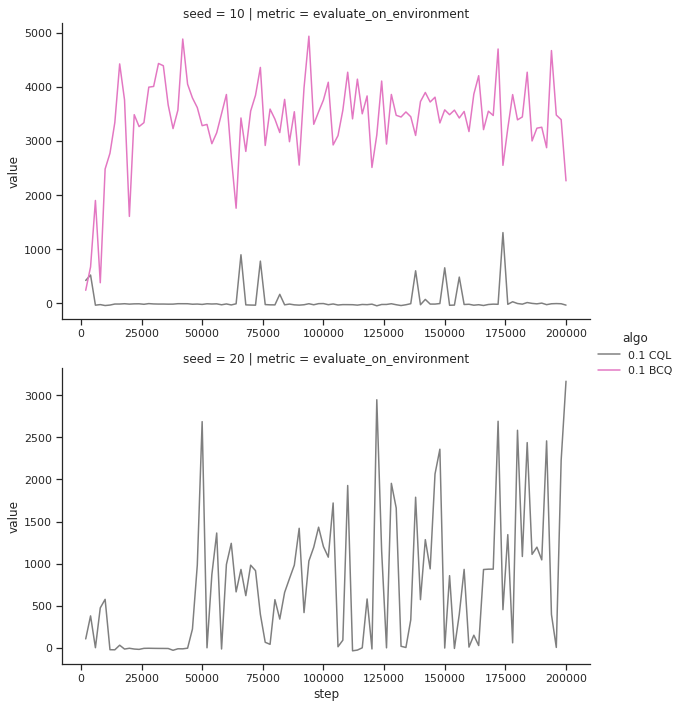

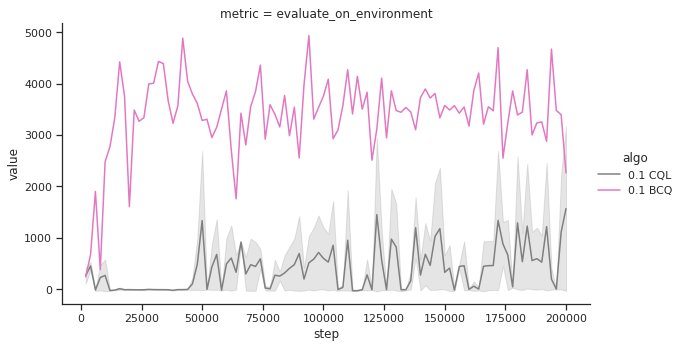

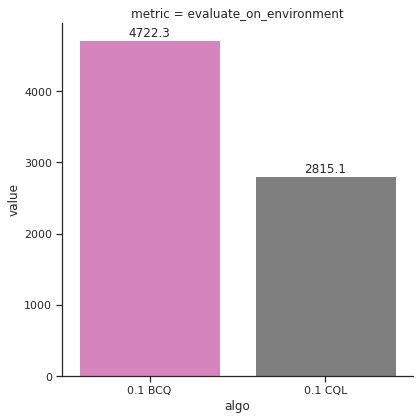

In [247]:
run_visualizer()

### Find the best model

In [256]:


algos = ["0.2 CQL", "0.2 AugmentedCQL"]
#seed = 

df = tables['Walker2d-v2']
#df = tables['HalfCheetah-v2']

df = df.loc[df['metric'].isin(['evaluate_on_environment'])]
df = df.loc[df['algo'].isin(algos)]
#df = df.loc[df['seed'].isin([seed])]
df = df.drop(columns =['step', 'metric'], errors='ignore') 
df = df[df['epoch'] % 10 == 0]  #select multiple of 10 (only rows when I save videos)
df = df.sort_values(by=['value'], ascending = False)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

   seed              algo  epoch        value
1    10  0.2 AugmentedCQL     50  2764.544403
1    10  0.2 AugmentedCQL     30  2620.748744
1    10  0.2 AugmentedCQL    100  2408.569187
1    20           0.2 CQL     90  2386.559534
1    20           0.2 CQL     70  2312.435526
1    20           0.2 CQL     60  2101.743175
1    20  0.2 AugmentedCQL    100  2056.669359
1    10           0.2 CQL     70  2049.263587
1    20           0.2 CQL    100  2042.632886
1    20  0.2 AugmentedCQL     90  1736.382051
1    10  0.2 AugmentedCQL     70  1597.445062
1    20  0.2 AugmentedCQL     60  1529.060302
1    10  0.2 AugmentedCQL     60  1520.418752
1    20           0.2 CQL     80  1511.568660
1    20  0.2 AugmentedCQL     50  1364.763843
1    10           0.2 CQL     80  1317.437809
1    20  0.2 AugmentedCQL     80  1293.853084
1    20  0.2 AugmentedCQL     70  1255.162772
1    20           0.2 CQL     30  1253.983111
1    10           0.2 CQL     40   977.737595
1    10           0.2 CQL    100  

### Delete rows from parquet

In [9]:
#env_name = "Walker2d-v2"
#col = "algo"
#items = ['0.1 AugmentedCQL', '0.15 AugmentedCQL', '0.2 AugmentedCQL']


path = "./results/{}/data_results.parquet".format(env_name)


df = tables[env_name]
df.drop(df[df[col].isin(items)].index, inplace = True)


df.to_parquet(path)

<AxesSubplot:xlabel='ratio', ylabel='value'>

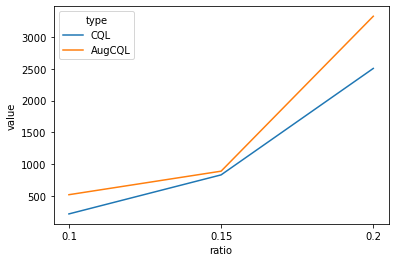

In [57]:
d = {'value': [214.6, 517.3, 829.5, 887.9, 2506.6, 3328.6], 
           'type': ['CQL','AugmentedCQL', 'CQL','AugmentedCQL', 'CQL','AugmentedCQL'], 
           'ratio': ['0.1', '0.1', '0.15', '0.15', '0.2', '0.2']}
df = pd.DataFrame(data = d)
sns.lineplot(data=df, x="ratio", y="value", hue="type")
